In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import datasets, svm, metrics

import numpy as np
import re
import copy
import graphviz
import scipy as sp  
import matplotlib.pyplot as plt
import dot2tex
import numpy as np
import pydotplus

from sklearn.metrics import accuracy_score

from scipy.special import gamma, factorial
from sklearn.model_selection import train_test_split
from scipy.special import gammaln
from decimal import Decimal
from scipy import special
from numpy import exp



data = load_breast_cancer()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']
full_data = load_breast_cancer()
feature_names = full_data.feature_names
labels_names = full_data.target_names

In [4]:
## https://github.com/jpnevrones/Decision-Tree-CART-/blob/master/DecisionTree/DecisionTree.py
# https://github.com/jpnevrones/Decision-Tree-CART-
#


class DecisionTree(object):
    """
    Class to create decision tree model (CART)
    """
    def __init__(self, alpha = 0.5, beta = 0.5, prob = [0.25]*4):
        self.alpha = alpha
        self.beta = beta
        self.name = "10X"
        self.nodes = [0]
        self.prob = prob
        #self.depth = 1

    def copy(self):
        new_tree = DecisionTree(alpha= self.alpha, beta = self.beta)
        new_tree.alpha = self.alpha
        new_tree.beta = self.beta
        new_tree.name = self.name
        new_tree.feature = self.feature
        new_tree.label = self.label 
        new_tree.train_data = self.train_data
        new_tree.categories = self.categories
        new_tree.colors_rgb = self.colors_rgb
        new_tree.root = copy.deepcopy(self.root)
        new_tree.nodes = self.nodes
        new_tree.shape = self.shape
        new_tree.feature_names = self.feature_names
        new_tree.label_names = self.label_names
        new_tree.alpha_prior = self.alpha_prior
        return new_tree

    def fit(self, _feature, _label):
        """

        :param _feature:
        :param _label:
        :return:
        """
        self.feature = _feature
        self.label = _label
        
        self.train_data = np.column_stack((self.feature,self.label))
        self.build_tree()
    
    
    def fit_MC(self, _feature, _label, alpha_prior=None):
        """

        :param _feature:
        :param _label:
        :return:
        """
        #Data
        self.feature = _feature
        self.label = _label
        self.categories = np.unique(_label)
        self.train_data = np.column_stack((self.feature,self.label))
        self.shape = ( np.shape(self.feature)[-1] , len(self.categories) ) 
        if alpha_prior is None:
            self.alpha_prior = np.array([1]* (self.shape[1]))
        elif self.shape[1] == len(alpha_prior):
            self.alpha_prior = alpha_prior
        else:
            print("Mal Dimension de 'alpha_prior' ")
            self.alpha_prior = None
            
        
        #Estetica
        self.feature_names = [f"x_{x}" for x in range(self.shape[0])]
        self.label_names = [f"c_{x}" for x in range(self.shape[1])]
        self.colors_rgb = self._color_brew(self.shape[1])
        
        self.build_tree_MC()
        
    def reset_labels(self):
        self.feature_names = [f"$x_{x}$" for x in range(self.shape[0])]
        self.label_names = [f"$c_{x}$" for x in range(self.shape[1])]
        
    def set_labels(self, feature_names,label_names):
        if ( (len(feature_names), len(label_names) ) == self.shape):
            self.feature_names = feature_names
            self.label_names = label_names
        else:
            print("Dimensión incorrecta")


    def compute_gini_similarity(self, groups, class_labels):
        """
        compute the gini index for the groups and class labels

        :param groups:
        :param class_labels:
        :return:
        """
        num_sample = sum([len(group) for group in groups])
        gini_score = 0

        for group in groups:
            size = float(len(group))

            if size == 0:
                continue
            score = 0.0
            for label in class_labels:
                porportion = (group[:,-1] == label).sum() / size
                score += porportion * porportion
            gini_score += (1.0 - score) * (size/num_sample)

        return gini_score
    
    def p_split(self, alpha, altura, beta):
        return alpha*(1+altura)**(-beta)

    def terminal_node(self, _group):
        """
        Function set terminal node as the most common class in the group to make prediction later on
        is an helper function used to mark the leaf node in the tree based on the early stop condition
        or actual stop condition which ever is meet early
        :param _group:
        :return:
        """
        class_labels, count = np.unique(_group[:,-1], return_counts= True)
        return class_labels[np.argmax(count)]

    def split(self, index, val, data):
        """
        split features into two groups based on their values
        :param index:
        :param val:
        :param data:
        :return:
        """
        data_left = np.array([]).reshape(0,self.train_data.shape[1])
        data_right = np.array([]).reshape(0, self.train_data.shape[1])

        for row in data:
            if row[index] <= val :
                data_left = np.vstack((data_left,row))

            if row[index] > val:
                data_right = np.vstack((data_right, row))

        return data_left, data_right

    def best_split(self, data):
        """
        find the best split information using the gini score
        :param data:
        :return best_split result dict:
        """
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        for idx in range(data.shape[1]-1):
            for row in data:
                groups = self.split(idx, row[idx], data)
                gini_score = self.compute_gini_similarity(groups,class_labels)

                if gini_score < best_score:
                    best_index = idx
                    best_val = row[idx]
                    best_score = gini_score
                    best_groups = groups
        result = {}
        result['index'] = best_index
        result['val'] = best_val
        result['groups'] = best_groups
        return result



    def insert(self, source_str, insert_str, pos):
        return source_str[:pos] + insert_str + source_str[pos:]

    def split_MC(self, data):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        idx = np.random.choice(range(data.shape[1]-1))
        val_aux = np.random.choice(np.unique(data[:,idx]))
        groups = self.split(idx, val_aux, data)
        gini_score = self.compute_gini_similarity(groups,class_labels)


        if True : #gini_score < best_score:
            best_index = idx
            best_val = val_aux
            best_score = gini_score
            best_groups = groups
        result = {}
        result["depth"] = 1
        result['index'] = best_index
        result['val'] = best_val
        result['groups'] = best_groups
        left_node, right_node = best_groups
        result["left"] = self.terminal_node(left_node)
        result["right"] = self.terminal_node(right_node)
        
        #Agregar if len(groups)==0, para que no haga vacio.
        
        n_ik = self.compute_n_ik(best_groups)
        result["n_ik"] = n_ik

        return result


    def compute_alpha_score(self):
        return 0.5

    def split_MC2(self, U, node, data):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        idx = np.random.choice(range(data.shape[1]-1))
        val_aux = np.random.choice(data[:,idx])
        groups = self.split(idx, val_aux, data)
        gini_score = self.compute_gini_similarity(groups,class_labels)

        alpha_score = self.compute_alpha_score()

        if U < alpha_score:
            best_index = idx
            best_val = val_aux
            best_score = gini_score
            best_groups = groups
            result = {}
            result["depth"] = node["depth"]+1
            result['index'] = best_index
            result['val'] = best_val
            result['groups'] = best_groups
            left_node, right_node = best_groups
            result["left"] = self.terminal_node(left_node)
            result["right"] = self.terminal_node(right_node)
            node["left"] = result


    def light_root(self, tree = None):
        
        if tree is None:
            tree_aux = copy.deepcopy(self.root)
            del(tree_aux["groups"])
            tree_aux["left"] = self.light_root(tree_aux["left"])
            tree_aux["right"] = self.light_root(tree_aux["right"])
            return tree_aux
        else:
            tree_aux = tree
            if isinstance(tree_aux , dict):
                del(tree_aux["groups"])
                tree_aux["left"] = self.light_root(tree_aux["left"])
                tree_aux["right"] = self.light_root(tree_aux["right"])
                return tree_aux
            else:
                return tree
                

    def get_node_by_path(self, tree, string):
        if len(string)==0:
          return tree
        path = string[0]
        if path == 1:
          node = tree["left"]
        if path == 2:
          node = tree["right"]
        return self.get_node_by_path(node,string[1:])
                                     

    # def set_node_by_path(self, tree, string):
    #     if len(string)==0:
    #       return tree
    #     path = string[0]
    #     if path == 1:
    #       node = tree["left"]
    #     if path == 2:
    #       node = tree["right"]
    #     return self.get_node_by_path(node,string[1:])

    def get_path(self, string):
        string_aux=string
        while len(re.findall("12*0",string_aux))>0:
          string_aux = re.sub("12*0","2", string_aux)
        return string_aux

    def _color_brew(self, n):
        """Generate n colors with equally spaced hues.
        Parameters
        ----------
        n : int
            The number of colors required.
        Returns
        -------
        color_list : list, length n
            List of n tuples of form (R, G, B) being the components of each color.
        """
        color_list = []

        # Initialize saturation & value; calculate chroma & value shift
        s, v = 0.75, 0.9
        c = s * v
        m = v - c

        for h in np.arange(25, 385, 360.0 / n).astype(int):
            # Calculate some intermediate values
            h_bar = h / 60.0
            x = c * (1 - abs((h_bar % 2) - 1))
            # Initialize RGB with same hue & chroma as our color
            rgb = [
                (c, x, 0),
                (x, c, 0),
                (0, c, x),
                (0, x, c),
                (x, 0, c),
                (c, 0, x),
                (c, x, 0),
            ]
            r, g, b = rgb[int(h_bar)]
            # Shift the initial RGB values to match value and store
            rgb = [(int(255 * (r + m))), (int(255 * (g + m))), (int(255 * (b + m)))]
            color_list.append(rgb)

        return color_list
        
    
    def color_alpha(self, alpha, color):
        # compute the color as alpha against white
        color0 = [int(round(alpha * c + (1 - alpha) * 255, 0)) for c in color]
        # Return html color code in #RRGGBB format
        return "#%2x%2x%2x" % tuple(color0)
    
    
    def compute_n_ik(self, grupos):
        left_node, right_node = grupos
        categories = self.categories.reshape(-1,1)
#         print (categories)
#         print ((left_node[:,-1] == categories))
        n_ik = ((left_node[:,-1] == categories).sum(axis=1), (right_node[:,-1] == categories).sum(axis=1))
        return n_ik


    def split_MC3(self):

        #Cambiar para  que no se pueda elegir split que generan conjuntos vacios( sale en el paper que no se pueden generar vacios)
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        name = self.name
        #Eligimos split aleatorio
        matches = re.finditer("([X0])",name)
        matches = list(matches)
        # Cambiar con respecto a la altura
        rand_grow_match_index=np.random.choice(range(len(matches)))
        rand_grow_index=matches[rand_grow_match_index].start()
        
        raw_path = name[:rand_grow_index]
        path = self.get_path(raw_path)
        #print("raw ", raw_path)
        #print("camino ", path)
        last_order = path[-1]
        path = path[:-1]
        
        tree = self.root
        while  len(path)>0:
            order = path[0]
            if order == "1":
                tree = tree["left"]
            if order == "2":
                tree = tree["right"]
            path = path[1:]

        # print("tree ",tree)
        # data = tree['groups'][0]
        if last_order=="1": 
            #print("if")
            data = tree['groups'][0]
        elif last_order=="2":
            #print("else")
            data = tree['groups'][1]

        father_depth = tree["depth"]
        #print(last_order)
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        idx = np.random.choice(range(data.shape[1]-1))
        val_aux = np.random.choice(data[:,idx])
        groups = self.split(idx, val_aux, data)
        gini_score = self.compute_gini_similarity(groups,class_labels)


        if True : #gini_score < best_score:
            best_index = idx
            best_val = val_aux
            best_score = gini_score
            best_groups = groups
        result = {}
        result["depth"] = father_depth+1
        result['index'] = best_index
        result['val'] = best_val
        result['groups'] = best_groups
        left_node, right_node = best_groups

        #Agregue esta linea
        if len(right_node)==0 or len(left_node)==0:
            self.split_MC3()
            return
        result["left"] = self.terminal_node(left_node)
        result["right"] = self.terminal_node(right_node)
        # Se nos habia olvidado mutear esto y right estaba escrito como rigth xd
         # tree["left"] = result

        
        if last_order=="1":
            #print("ultimo last order 1")
            tree["left"] = result
        elif last_order=="2":
            #print("ultimo last order 2")
            tree["right"] = result

        #Cambiamos el nombre
        self.name = self.insert(name,"10",rand_grow_index)
        

    def random_choice(self, array):
        # "Given a estocastical vector choose value based on U uniform dist"
        p_acum=0
        U = np.random.uniform(0,1)
        for i, p in enumerate(array):
            p_acum += p
            if U <= p_acum:
                return i
        return i
        
    def get_num_operation(self, name = None):
        if name is None:
            name = self.name
        #Split
        matches0 = re.finditer("([X0])",name)
        matches0 = list(matches0)
        
        #Numero de splits posibles
        N_split = len(matches0)
        
        
        matches1 = re.finditer("10([X0])",name)
        matches1 = list(matches1)
        
        #Numero de prunes posibles
        if name == "10X":
            N_prune = 0
        else:
            N_prune = len(matches1)
        
        #Elegiir no interno no pruneable (tiene como hijo al menos un nodo interno)

        matches2 = re.finditer("([^0X])",name)
        matches2 = list(matches2)
        
        matches1_index = [match.start() for match in matches1]
        matches2_index = [match.start() for match in matches2]
        matches3_index = [x for x in matches2_index if x not in matches1_index]
        
         #Numero de swaps posibles
        N_swap = len(matches3_index)
        
        N_change = len(matches2)
        return np.array([N_split, N_prune, N_change, N_swap])
        
    def split_MC4(self, n = 0):
        alpha = self.alpha
        beta = self.beta
        prob = np.array(self.prob)
        #Cambiar para  que no se pueda elegir split que generan conjuntos vacios( sale en el paper que no se pueden generar vacios)
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        name = self.name
        #Eligimos split aleatorio
        matches = re.finditer("([X0])",name)
        matches = list(matches)
        
        #Numero de splits posibles
        N_split = len(matches)
        
        # Calculamos las probabilidades de  p_split
        rand_grow_indexes=[match.start() for match in matches]
        
        raw_paths = [name[:rand_grow_index] for rand_grow_index in rand_grow_indexes]
        paths = [self.get_path(raw_path) for raw_path in raw_paths]
        p_splits = np.array([self.p_split(alpha, len(path), beta ) for path in paths])
        sum_p_splits = sum(p_splits)
        p_split_stand = p_splits/sum_p_splits
        
        p_splits_mean = p_splits.mean()
        
        
        print(f"vector split stand: {p_split_stand} ")
#         print(f"suma vector stand : {sum(p_split_stand)} ")
        choice_path_index = self.random_choice(p_split_stand)
        
        #Elegimos el indice con los pesos de p_split
#         print(f"eleccion : {choice_path_index} ")
#         print(choice_path_index)
        path = paths[choice_path_index]
        
#         print("raw ", raw_path)
#         print("camino ", path)
        last_order = path[-1]
        path = path[:-1]
        
        tree = self.root
        while  len(path) > 0:
            order = path[0]
            if order == "1":
                tree = tree["left"]
            if order == "2":
                tree = tree["right"]
            path = path[1:]

        # print("tree ",tree)
        # data = tree['groups'][0]
        if last_order=="1": 
#             print("if")
            data = tree['groups'][0]
        elif last_order=="2":
#             print("else")
            data = tree['groups'][1]

        father_depth = tree["depth"]
#         print(last_order)
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        idx = np.random.choice(range(data.shape[1]-1))
        val_aux = np.random.choice(np.unique(data[:,idx]))
        groups = self.split(idx, val_aux, data)
        gini_score = self.compute_gini_similarity(groups,class_labels)

        if True : #gini_score < best_score:
            best_index = idx
            best_val = val_aux
            best_score = gini_score
            best_groups = groups
        result = {}
        result["depth"] = father_depth+1
        result['index'] = best_index
        result['val'] = best_val
        result['groups'] = best_groups
        left_node, right_node = best_groups

        #Agregue esta linea
        if len(right_node)==0 or len(left_node)==0:
            if n>300:
                return
            self.split_MC4(n=n+1)
            
            
            return
        result["left"] = self.terminal_node(left_node)
        result["right"] = self.terminal_node(right_node)
        n_ik = self.compute_n_ik(best_groups)
        result["n_ik"] = n_ik
        # Se nos habia olvidado mutear esto y right estaba escrito como rigth xd
         # tree["left"] = result

        
        if last_order=="1":
#             print("ultimo last order 1")
            tree["left"] = result
        elif last_order=="2":
#             print("ultimo last order 2")
            tree["right"] = result

        #Cambiamos el nombre
        #rand_grow_index = rand_grow_indexes[choice_path_index]
        
        rand_grow_index = rand_grow_indexes[choice_path_index]
        new_name = self.insert(name,"10",rand_grow_index)
        matches_prune = re.finditer("10([X0])",new_name)
        matches_prune = list(matches_prune)

        
        ####################
        
        #Numero de prunes (T*) posibles
        N_prune = len(matches_prune)

        # Calculamos las probabilidades de  prune
        rand_prune_indexes = [match_prune.start() for match_prune in matches_prune]
        raw_paths_prune = [new_name[:rand_prune_index] for rand_prune_index in rand_prune_indexes]
        paths_prune = [self.get_path(raw_path_prune) for raw_path_prune in raw_paths_prune]
        p_prunes = 1 - np.array([self.p_split(alpha, len(path), beta ) for path in paths])
        
        p_prunes_mean = p_prunes.mean()
        
        N_Ti = self.get_num_operation(name)
        N_Tf = self.get_num_operation(new_name)
        
        B_tree_split = (p_splits_mean/p_prunes_mean) * ((N_Ti*prob).sum()/((N_Tf*prob).sum()))  *  (prob[1] / prob[0]) * ( 1 - self.p_split(alpha,len(path)+1,beta))**2
        self.name = new_name
        
        return B_tree_split
    
    def P_YX(self):
        alphal = self.alpha_prior
        #alpha = 0.5
        #eta = 0.5
        #Cambiar para  que no se pueda elegir split que generan conjuntos vacios( sale en el paper que no se pueden generar vacios)
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        name = self.name
        #Eligimos split aleatorio
        matches = re.finditer("([X0])",name)
        matches = list(matches)
        b = len(matches)
        
        # Calculamos las probabilidades de  p_split
        rand_grow_indexes=[match.start() for match in matches]
        n = np.zeros((b,len(self.categories)))
        
        raw_paths = [name[:rand_grow_index] for rand_grow_index in rand_grow_indexes]
        paths = [self.get_path(raw_path) for raw_path in raw_paths]
        for i, path in enumerate(paths):
            last_order = path[-1]
            path = path[:-1]
            
            tree = self.root
            while  len(path) > 0:
                order = path[0]
                if order == "1":
                    tree = tree["left"]
                if order == "2":
                    tree = tree["right"]
                path = path[1:]

            if last_order=="1": 
    #             print("if")
                data = tree['n_ik'][0]
            elif last_order=="2":
    #             print("else")
                data = tree['n_ik'][1]
            n[i,:] = data

        pt = b * (gammaln(np.sum(alphal)) - np.sum(gammaln(alphal)))
        alphal1 = alphal.reshape((-1, len(self.categories)))
        a = np.sum( np.sum(gammaln(n + alphal1), axis = 1)  - gammaln(np.sum(n, axis =1) + np.sum(alphal)), axis = 0 )   
        return a + pt

    def extract (self, source_str, len_extract_str, pos):
        return source_str[:pos] + source_str[pos+len_extract_str:]

    def prune_MC3(self):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        alpha = self.alpha
        beta = self.beta
        prob = np.array(self.prob)

        name = self.name
        if name == "10X":
            print("Árbol minimo no se puede podar")
            N_prune = 0
            return
        #Elegimos prune aleatorio
        matches = re.finditer("10([X0])",name)
        matches = list(matches)
        
        ####################
        
        #Numero de splits posibles
        N_prune = len(matches)
        
        # Elejimos prune aleatorio
        # Calculamos las probabilidades de  prune
        rand_prune_indexes=[match.start() for match in matches]
        
        raw_paths = [name[:rand_prune_index] for rand_prune_index in rand_prune_indexes]
        paths = [self.get_path(raw_path) for raw_path in raw_paths]
        p_prunes = 1 - np.array([self.p_split(alpha, len(path), beta ) for path in paths])
        sum_p_prunes = sum(p_prunes)
        p_prune_stand = p_prunes/sum_p_prunes
        
        p_prunes_mean = p_prunes.mean()
        
        
        print(f"vector prune stand: {p_prune_stand} ")
        choice_path_index = self.random_choice(p_prune_stand)
        path = paths[choice_path_index]

        last_order = path[-1]
        path_original = path
        path = path[:-1]
        
        
        tree = self.root
        while  len(path)>0:
            order = path[0]
            if order == "1":
                tree = tree["left"]
            if order == "2":
                tree = tree["right"]
            path = path[1:]

        # print("tree ",tree)
        # data = tree['groups'][0]
        if last_order=="1": 
            print("if")
            data = tree['groups'][0]
            tree["left"] = self.terminal_node(data)
        elif last_order=="2":
            print("else")
            data = tree['groups'][1]
            tree["right"] = self.terminal_node(data)
            
        # Calculamos las probabilidades de  p_split
        
        
        rand_prune_index =  rand_prune_indexes[choice_path_index]
        new_name = self.extract(name,2,rand_prune_index)
        
        #Eligimos split
        matches_split = re.finditer("([X0])",new_name)
        matches_split = list(matches_split)
        
        rand_grow_indexes=[match_split.start() for match_split in matches_split]
        
        raw_paths_split = [new_name[:rand_grow_index] for rand_grow_index in rand_grow_indexes]
        paths_split  = [self.get_path(raw_path_split ) for raw_path_split  in raw_paths_split ]

        p_splits = np.array([self.p_split(alpha , len(path_split ), beta ) for path_split  in paths_split ])
        sum_p_splits = sum(p_splits)
        p_splits_mean = p_splits.mean()
        
        N_Ti = self.get_num_operation(name)
        N_Tf = self.get_num_operation(new_name)
        
        B_tree_prune  =(p_prunes_mean/p_splits_mean) * ((N_Ti*prob).sum()/((N_Tf*prob).sum())) * (prob[0] / prob[1]) * ( 1 - self.p_split(alpha , len(path_original)+1, beta ))**(-2)
        
        #Cambiamos el Nombre
        self.name = self.extract(name,2,rand_prune_index)
        return B_tree_prune



    def change_MC2(self):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        name = self.name
        #Elegimos nodo interno aleatorio para change
        matches = re.finditer("([^X0])",name)
        matches = list(matches)
        # Cambiar con respecto a la altura
        rand_change_match_index=np.random.choice(range(len(matches)))
        rand_change_index=matches[rand_change_match_index].start()
        raw_path = name[:rand_change_index]
        path = self.get_path(raw_path)
        #print("raw ", raw_path)
        #print("camino ", path)
        
        tree = self.root
        while  len(path)>0:
            order = path[0]
            if order == "1":
                tree = tree["left"]
            if order == "2":
                tree = tree["right"]
            path = path[1:]

        data = np.concatenate(tree["groups"],axis=0)
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        idx = np.random.choice(range(data.shape[1]-1))
        val_aux = np.random.choice(np.unique(data[:,idx]))
        tree['index'] = idx
        tree['val'] = val_aux
        # print("tree ",tree)
        # data = tree['groups'][0]

    def update_tree(self, tree, data_prev=None):
        """
        given a tree dict anotation, with new decision rules
        return (bool , tree) where bool if feasuble tree and
        tree with correct grupes.

        """
        # Check if tree is a leaf
        
        if not isinstance(tree,dict):
            if data_prev is None:
                return True, tree
            else:
                return True, self.terminal_node(data_prev)

        if data_prev is None:
            data = np.concatenate(tree["groups"],axis=0)
        else:
            data = data_prev

        depth = tree["depth"]
        idx = tree['index']
        val_aux = tree['val']
        groups = self.split(idx, val_aux, data)

        if len(groups[0])==0 or len(groups[1])==0:
            return False, None 
        left_node = tree["left"]
        right_node = tree["right"]
        
        bool_left, tree_left = self.update_tree(left_node, groups[0])  
        bool_right, tree_right = self.update_tree(right_node, groups[1])
        n_ik = self.compute_n_ik(groups)
        tree["n_ik"] = n_ik
        

        # Si alguno es falso returnar que no se pudo (False, None)
        # If any is False return (False, None) (We cant change)
        if not (bool_left and bool_right):
            return False, None
        
        tree_aux = copy.deepcopy(tree)

        tree_aux["groups"] = groups
        tree_aux["left"] = tree_left
        tree_aux["right"] = tree_right

        return True, tree_aux




    def change_MC3(self, n=0):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        self.change_MC2()
        condition , tree = self.update_tree(self.root)
        if n>10:
            #print("Se intento mucho")
            return None

        if condition :
            self.root = tree
            #print(f"{n+1} intentos ")
            return 1 # Valor de B = q(Ti,Ti+1)P(Ti+1)/q(Ti+1,Ti)P(Ti) 
        else: 
            self.change_MC3(n+1)


    def swap_MC2(self):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        name = self.name
        #Elegiir no interno no pruneable (tiene como hijo al menos un nodo interno)
        matches1 = re.finditer("10([0X])",name)
        matches1 = list(matches1)

        matches2 = re.finditer("([^0X])",name)
        matches2 = list(matches2)
        matches1_index = [match.start() for match in matches1]
        matches2_index = [match.start() for match in matches2]
        matches3_index = [x for x in matches2_index if x not in matches1_index]
        if len(matches3_index)==0:
            print("No swap posible")
            return None
        # Cambiar con respecto a la altura
        rand_change_index = np.random.choice(matches3_index)
        raw_path = name[:rand_change_index]
        path = self.get_path(raw_path)
        print("raw ", raw_path)
        print("camino ", path)
        
        tree_aux = copy.deepcopy(self.root)
        tree = tree_aux
        while  len(path)>0:
            order = path[0]
            if order == "1":
                tree = tree["left"]
            if order == "2":
                tree = tree["right"]
            path = path[1:]

        idx = tree['index'] 
        val_aux = tree['val']

        tree_left = tree["left"]
        tree_right = tree["right"]
        if isinstance(tree_left,dict) and isinstance(tree_right,dict):
            #Falta agregar que si los dos hijos tienen la misma regla, cambiar ambos hijos
            if np.random.randint(2) == 0:
                tree['index'], tree_left['index'] = tree_left['index'], tree['index']
                tree['val'], tree_left['val'] = tree_left['val'], tree['val']
            else:
                tree['index'], tree_right['index'] = tree_right['index'], tree['index']
                tree['val'], tree_right['val'] = tree_right['val'], tree['val']

        elif isinstance(tree_left,dict):
            tree['index'], tree_left['index'] = tree_left['index'], tree['index']
            tree['val'], tree_left['val'] = tree_left['val'], tree['val']

        elif isinstance(tree_right,dict):
            tree['index'], tree_right['index'] = tree_right['index'], tree['index']
            tree['val'], tree_right['val'] = tree_right['val'], tree['val']

        return tree_aux
    

    def swap_MC3(self,n=0):
        """
         split information using Montecalo
        :param data:
        :return best_split result dict:
        """
        tree_aux = self.swap_MC2()
        if not tree_aux is None:
            condition , tree = self.update_tree(tree_aux)
        else: 
            condition = False
        if n>10:
            print("Se intento mucho")
            return None

        if condition :
            self.root = tree
            print(f"{n+1} intentos ")
            return 1 # Valor de B = q(Ti,Ti+1)P(Ti+1)/q(Ti+1,Ti)P(Ti) 
        else: 
            self.swap_MC3(n+1)



    def split_branch(self, node, depth):
        """
        recursively split the data and
        check for early stop argument based on self.max_depth and self.min_splits
        - check if left or right groups are empty is yess craete terminal node
        - check if we have reached max_depth early stop condition if yes create terminal node
        - Consider left node, check if the group is too small using min_split condition
            - if yes create terminal node
            - else continue to build the tree
        - same is done to the right side as well.
        else
        :param node:
        :param depth:
        :return:
        """
        left_node , right_node = node['groups']
        #del(node['groups'])

        if not isinstance(left_node,np.ndarray) or not isinstance(right_node,np.ndarray):
            node['left'] = self.terminal_node(left_node + right_node)
            node['right'] = self.terminal_node(left_node + right_node)
            return

        if depth >= self.max_depth:
            node['left'] = self.terminal_node(left_node)
            node['right'] = self.terminal_node(right_node)
            return

        if len(left_node) <= self.min_splits:
            node['left'] = self.terminal_node(left_node)
        else:
            node['left'] = self.best_split(left_node)
            self.split_branch(node['left'],depth + 1)


        if len(right_node) <= self.min_splits:
            node['right'] = self.terminal_node(right_node)
        else:
            node['right'] = self.best_split(right_node)
            self.split_branch(node['right'],depth + 1)

    def split_branch_MC(self, node, depth =1):
        """
        recursively split the data and
        check for early stop argument based on self.max_depth and self.min_splits
        - check if left or right groups are empty is yess craete terminal node
        - check if we have reached max_depth early stop condition if yes create terminal node
        - Consider left node, check if the group is too small using min_split condition
            - if yes create terminal node
            - else continue to build the tree
        - same is done to the right side as well.
        else
        :param node:
        :param depth:
        :return:
        """
        left_node , right_node = node['groups']
        del(node['groups'])

        if not isinstance(left_node,np.ndarray) or not isinstance(right_node,np.ndarray):
            node['left'] = self.terminal_node(left_node + right_node)
            node['right'] = self.terminal_node(left_node + right_node)
            return

        if depth >= self.max_depth:
            node['left'] = self.terminal_node(left_node)
            node['right'] = self.terminal_node(right_node)
            return

        if len(left_node) <= self.min_splits:
            node['left'] = self.terminal_node(left_node)
        else:
            node['left'] = self.best_split(left_node)
            self.split_branch(node['left'],depth + 1)


        if len(right_node) <= self.min_splits:
            node['right'] = self.terminal_node(right_node)
        else:
            node['right'] = self.best_split(right_node)
            self.split_branch(node['right'],depth + 1)

    def build_tree(self):
        """
        build tree recursively with help of split_branch function
         - Create a root node
         - call recursive split_branch to build the complete tree
        :return:
        """
        self.root = self.best_split(self.train_data)
        self.split_branch(self.root, 1)
        return self.root

    def build_tree_MC(self):
        """
        build tree recursively with help of split_branch function
         - Create a root node
         - call recursive split_branch to build the complete tree
        :return:
        """
        self.root = self.split_MC(self.train_data)
        return self.root

    

    def _predict(self, node, row):
        """
        Recursively traverse through the tress to determine the
        class of unseen sample data point during prediction
        :param node:
        :param row:
        :return:
        """
        if row[node['index']] < node['val']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']

        else:
            if isinstance(node['right'],dict):
                return self._predict(node['right'],row)
            else:
                return node['right']

    def predict(self, test_data):
        """
        predict the set of data point
        :param test_data:
        :return:
        """
        self.predicted_label = np.array([])
        for idx in test_data:
            self.predicted_label = np.append(self.predicted_label, self._predict(self.root,idx))

        return self.predicted_label
    


    def write_nodes(self, dic, node=0):
        text = ""
        if not isinstance(dic,dict):
            return text

        left_node = self.nodes[-1] + 1
        self.nodes.append(left_node)
        text +=  "{} -> {} [color=\"green\"];\n".format(node, left_node)
        text += self.write_nodes(dic["left"], left_node)

        right_node = self.nodes[-1] + 1
        self.nodes.append(right_node)
        text +=  "{} -> {} [color=\"yellow\"];\n".format(node, right_node)
        text += self.write_nodes(dic["right"], right_node)
        return text

    def write_dot(self):
        dic = self.root
        self.nodes = [0]
        text = 'digraph Tree {\nnode [shape=box, style="filled", color="skyblue"] ;\n'
        text += self.write_nodes(dic)
        text += "}"
        return text



    def write_nodes2(self, dic, feature_names, label_names, node=0):
        text = ""
        if not isinstance(dic,dict):
            return text

        pre_text = ('{}  [label="{} <= {}\\nsamples = ',
                '{}\\nvalue = {}\\nclass = {}", fillcolor={}];\n')

        pre_text2 = ('{}  [label="samples = {}',
                '\\nvalue = {}\\nclass = {}", fillcolor={}];\n')

        value = sum(dic["n_ik"])
        text +=  "".join(pre_text).format(node, feature_names[dic["index"]],
                                         dic["val"], sum(value), value, label_names[np.argmax(value)], "orange")

        #if isinstance(dic["left"], dict) and isinstance(dic["right"], dict) :
        left_node = self.nodes[-1] + 1
        self.nodes.append(left_node)
        text +=  "{} -> {} [color=\"green\"];\n".format(node, left_node)

        left_dict = dic["left"]
        if isinstance(left_dict, dict): 
            text += self.write_nodes2(left_dict, feature_names, label_names, left_node)
        else:
            value = dic["n_ik"][0]
            text +=  "".join(pre_text2).format(left_node,sum(value), value,
                                          label_names[np.argmax(value)], "orange")

        right_node = self.nodes[-1] + 1
        self.nodes.append(right_node)
        text +=  "{} -> {} [color=\"yellow\"];\n".format(node, right_node)

        right_dict = dic["right"]
        if isinstance(right_dict, dict): 
            text += self.write_nodes2(right_dict, feature_names, label_names, right_node)
        else:
            value = dic["n_ik"][1]
            text +=  "".join(pre_text2).format(right_node,sum(value), value,
                                          label_names[np.argmax(value)], "orange")
        return text

    def write_dot2(self):
        dic = self.root
        feature_names = self.feature_names
        label_names = self.label_names
        self.nodes = [0]
        text = 'digraph Tree {\nnode [shape=box, style="filled", color="skyblue"] ;\n'
        text += self.write_nodes2(dic, feature_names, label_names)
        text += "}"
        return text
    


    def write_nodes3(self, dic, feature_names, label_names, colors, node=0):
        text = ""

        if not isinstance(dic,dict):
            return text

        pre_text = ('{}  [label="{} <= {}\\nsamples = ',
                '{}\\nvalue = {}\\nclass = {}", fillcolor="{}"];\n')

        pre_text2 = ('{}  [label="samples = {}',
                '\\nvalue = {}\\nclass = {}", fillcolor="{}"];\n')


        value = sum(dic["n_ik"])
        total = sum(value)
        cat_index = np.argmax(value)
        pre_color = colors[cat_index]
        alpha = 2*value[cat_index]/total-1
        color = self.color_alpha(alpha, pre_color)
        text +=  "".join(pre_text).format(node, feature_names[dic["index"]],
                                         dic["val"], total, value, label_names[np.argmax(value)], color)

        #if isinstance(dic["left"], dict) and isinstance(dic["right"], dict) :
        left_node = self.nodes[-1] + 1
        self.nodes.append(left_node)
        text +=  "{} -> {} [color=\"green\"];\n".format(node, left_node)

        left_dict = dic["left"]
        if isinstance(left_dict, dict): 
            text += self.write_nodes3(left_dict, feature_names, label_names, colors, left_node)
        else:
            value = dic["n_ik"][0]
            total = sum(value)
            cat_index = np.argmax(value)
            pre_color = colors[cat_index]
            alpha = 2*value[cat_index]/total-1
            color = self.color_alpha(alpha, pre_color)
            text +=  "".join(pre_text2).format(left_node,total, value,
                                          label_names[np.argmax(value)], color)

        right_node = self.nodes[-1] + 1
        self.nodes.append(right_node)
        text +=  "{} -> {} [color=\"yellow\"];\n".format(node, right_node)

        right_dict = dic["right"]
        if isinstance(right_dict, dict): 
            text += self.write_nodes3(right_dict, feature_names, label_names, colors, right_node)
        else:
            value = dic["n_ik"][1]
            total = sum(value)
            cat_index = np.argmax(value)
            pre_color = colors[cat_index]
            alpha = 2*value[cat_index]/total-1
            color = self.color_alpha(alpha, pre_color)
            text +=  "".join(pre_text2).format(right_node,total, value,
                                          label_names[np.argmax(value)], color)


        return text

    def write_dot3(self):
        self.nodes = [0]
        dic = self.root
        feature_names = self.feature_names
        label_names = self.label_names
        colors = self.colors_rgb
        text = 'digraph Tree {\nnode [shape=box, style="filled", color="black"] ;\n'
        text += self.write_nodes3(dic, feature_names, label_names, colors)
        text += "}"
        return text

    
    def graph_structure(self):
        return graphviz.Source(self.write_dot(), format="png")
    
    def graph_info(self):
        return graphviz.Source(self.write_dot2(), format="png")
    
    def graph_desiciontree(self):
        return graphviz.Source(self.write_dot3(), format="png")
    
    def save_img(self, dir0):
        graph = self.graph_desiciontree()
        graph.render(dir0,cleanup=True)
        
    def save_img_hd(self, dir0):
        pydot_graph = pydotplus.graph_from_dot_data(self.write_dot3())
        pydot_graph.set_size('"20,20!"')
        pydot_graph.write_png(dir0 + ".png")

In [128]:
class BayesianDecisionTree(object):
    """
    Class to create decision tree model (CART)
    """
    def __init__(self, prob= [0.25,0.25,0.25,0.25], alpha = 0.5, beta = 0.5 , dynamic_prob = False):
        self.alpha = alpha
        self.beta = beta
        self.prob = prob
        self.path = []
        self.iteration = 0
        self.choices = []
        self.chosen = []
        self.feature_names = None
        self.labels_names = None
        self.dynamic_prob = []
    
    def copy(self):
        new_BayesianTree = BayesianDecisionTree()
        new_BayesianTree.alpha = self.alpha
        new_BayesianTree.beta = self.beta
        new_BayesianTree.prob = self.prob
        new_BayesianTree.path = self.path
        new_BayesianTree.iteration = self.iteration
        new_BayesianTree.choices = self.choices
        new_BayesianTree.chosen = self.chosen
        new_BayesianTree.feature_names = self.feature_names
        new_BayesianTree.labels_names = self.labels_names 
        new_BayesianTree.dynamic_prob = self.dynamic_prob 
        return new_BayesianTree

    def fit(self, n,X,Y, alpha_prior = None):
        alpha = self.alpha
        beta = self.beta
        
        if self.iteration == 0:
            tree = DecisionTree(alpha, beta)
            tree.fit_MC(X ,Y ,alpha_prior)
        else:
            tree = self.path[-1]
        
        
        self.alpha_prior = tree.alpha_prior
        

        
        operation = ["grow", "prune", "change", "swap"]
        
        U = np.random.uniform(size = n)
        V = np.random.uniform(size = n)
        self.path.append(tree)
        self.choices.append("start")
        self.chosen.append(True)
        
        for i in range(n):
            #choice = np.random.choice(operation)
            
            new_tree = tree.copy()
            dynamic_prob = new_tree.get_num_operation()
            self.dynamic_prob.append(list(dynamic_prob))
            prob_aux = np.array(self.prob) * dynamic_prob
            prob = prob_aux/(prob_aux.sum())
            
            p = 0
            for j, p_aux in enumerate(prob):
                p += p_aux
                if V[i] <= p:
                    choice = operation[j]
                    break
            
            #print("eleccion:", choice)
            if choice == "grow":
                B = new_tree.split_MC4()
            if choice == "prune":
                B = new_tree.prune_MC3()    
            if choice == "change":
                B = new_tree.change_MC3()
            if choice == "swap":
                B = new_tree.swap_MC3()
            #print("eleccion :", choice)
            #root = new_tree.light_root()
            #graph = graphviz.Source(write_dot2(root, feature_names, labels_names), format="png") 
            #graph.render(f"Grafos//grafo {i}")
            #p_tree = PT(tree.root, alpha, beta)
            #p_new_tree = PT(new_tree, alpha, beta)
            P_Y_tree = tree.P_YX()
            P_Y_new_tree = new_tree.P_YX()
            
            #print(P_Y_tree)
            #print("B choice :",choice, B)
            if not (B is None):
                print(f"prueba : {P_Y_new_tree - P_Y_tree}")
                A = np.min([1, B* np.exp(P_Y_new_tree - P_Y_tree)])
                if U[i] <= A:
                    tree = new_tree
                    self.chosen.append(True)
                else:
                    self.chosen.append(False)
            else:
                self.chosen.append(False)
            self.choices.append(choice)
            self.path.append(tree)
            
        self.iteration += n
        
        
    def fit_batch(self, n, batches, X, Y, alpha_prior = None):
        alpha = self.alpha
        beta = self.beta
        prob = self.prob
        
        if self.iteration == 0:
            tree = DecisionTree(alpha, beta)
            tree.fit_MC(X ,Y ,alpha_prior)
        else:
            tree = self.path[-1]
        
        self.alpha_prior = tree.alpha_prior
        
        operation = ["grow", "prune", "change", "swap"]
        
        U = np.random.uniform(size = n * batches)
        V = np.random.uniform(size = n * batches)
        self.path.append(tree)
        self.choices.append("start")
        self.chosen.append(True)
        
        for i in range(n):
            Beta_total =  1
            new_tree = tree.copy()
            choices = []
            for k in range(batches):
                #choice = np.random.choice(operation)
                p = 0
                for j, p_aux in enumerate(prob):
                    p += p_aux
                    if V[i*batches + k] <= p:
                        choice = operation[j]
                        break
                        
                
                #print("eleccion:", choice)
                if choice == "grow":
                    B = new_tree.split_MC4()
                    if not(B is None):
                        Beta_total *= B*prob[0]/prob[1]
                if choice == "prune":
                    B = new_tree.prune_MC3()
                    if not(B is None):
                        Beta_total *= B*prob[1]/prob[0]

                if choice == "change":
                    B = new_tree.change_MC3()
                    if not(B is None):
                        Beta_total *= B
                if choice == "swap":
                    B = new_tree.swap_MC3()
                    if not(B is None):
                        Beta_total *= B
                
                choices.append(choice)
            P_Y_tree = tree.P_YX()
            P_Y_new_tree = new_tree.P_YX()

            if not (Beta_total is None):
                print(f"prueba : {P_Y_new_tree - P_Y_tree}")
                A = np.min([1, Beta_total* np.exp(P_Y_new_tree - P_Y_tree)])
                if U[i] <= A:
                    tree = new_tree
                    self.chosen.append(True)
                else:
                    self.chosen.append(False)
            else:
                self.chosen.append(False)
            self.choices.append(choices)
            self.path.append(tree)
            
        self.iteration += n * batches
        
        
        
        
        
    def set_labels(self, feature_names,labels_names):
        self.feature_names = feature_names
        self.labels_names = labels_names
        
    def set_alpha(self, alpha):
        self.alpha = alpha
        
    def set_beta(self, beta):
        self.beta = beta
        
    def set_prob(self, prob):
        self.prob = prob
        
    def render_decisiontrees(self, dir0):
        path = self.path
        largo = len(path)
        largo_str = len(str(largo))
        for i, tree in enumerate(path):
            str_i = str(i)
            len_str_i = len(str_i)
            padding = "0"*(largo_str - len_str_i) + str_i
            if not ((self.feature_names is None) or (self.labels_names is None)):
                tree.set_labels(self.feature_names,self.labels_names)
                tree.save_img_hd(dir0+ "/" + padding)
                
    def tree_changes(self):
        path = np.array(self.path)
        largo = len(path)
        idx_chosen = np.arange(largo)[self.chosen]
        path_change = np.array(path)[idx_chosen]
        return path_change
                
    def render_changes(self, dir0):
        path_change = self.tree_changes()
        largo_2 = len(path_change)
        largo_str = len(str(largo_2))
        
        for i, tree in enumerate(path_change):
            str_i = str(i)
            len_str_i = len(str_i)
            padding = "0"*(largo_str - len_str_i) + str_i
            if not ((self.feature_names is None) or (self.labels_names is None)):
                tree.set_labels(self.feature_names,self.labels_names)
                tree.save_img_hd(dir0+ "/" + padding)

    def path_acurracy(self, X, y ):
        path = bayesian_tree.path
        accuracy = []
        for i, tree in enumerate(path):
            accuracy.append(accuracy_score(tree.predict(X), y))
        return accuracy
    

In [120]:
df = load_breast_cancer()
feature = df.data
label = df.target
X_train, X_test, y_train, y_test = train_test_split(feature, label, random_state= 42)

In [75]:
# prob = [0.5, 0.2, 0.2, 0.1]
# alpha = 0.8
# beta = 0.5
bayesian_tree = BayesianDecisionTree(alpha=0.5 , beta= 0.5)
bayesian_tree.fit_batch(300, 3 ,X_train,y_train)

vector split stand: [0.5 0.5] 
vector prune stand: [1.] 
if
vector split stand: [0.5 0.5] 
prueba : 0.6281090057784411
Árbol minimo no se puede podar
vector split stand: [0.5 0.5] 
vector split stand: [0.31010205 0.31010205 0.3797959 ] 
prueba : -2.387304197537077
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
Se intento mucho
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
Se intento mucho
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
Se intento mucho
prueba : 0.0
vector split stand: [0.5 0.5] 
vector prune stand: [1.] 
if
Árbol minimo no se puede podar
prue

prueba : 3.493645101260441
raw  101100
camino  22
1 intentos 
raw  101100
camino  22
1 intentos 
vector split stand: [0.22798615 0.16121055 0.16121055 0.16121055 0.1441911  0.1441911 ] 
prueba : -1.2076425332149086
vector prune stand: [0.4867671 0.5132329] 
else
raw  
camino  
raw  10
camino  2
2 intentos 
vector split stand: [0.26120387 0.18469903 0.18469903 0.18469903 0.18469903] 
prueba : 0.061725817135126704
vector prune stand: [0.4867671 0.5132329] 
if
vector prune stand: [0.5 0.5] 
if
vector split stand: [0.30952947 0.25272975 0.21887039 0.21887039] 
prueba : -31.38450830359811
raw  101100
camino  22
1 intentos 
vector split stand: [0.22798615 0.16121055 0.16121055 0.1441911  0.1441911  0.16121055] 
vector prune stand: [0.5 0.5] 
if
prueba : -0.9345441721834931
vector prune stand: [0.4867671 0.5132329] 
if
vector split stand: [0.26120387 0.18469903 0.18469903 0.18469903 0.18469903] 
prueba : -0.5537071777566496
vector split stand: [0.22798615 0.16121055 0.16121055 0.1441911  0.14

prueba : -164.61211275128346
raw  10
camino  2
1 intentos 
prueba : -13.004747118423438
raw  
camino  
raw  10
camino  2
2 intentos 
vector prune stand: [1.] 
if
prueba : -27.536976310644008
vector prune stand: [1.] 
if
vector split stand: [0.3797959  0.31010205 0.31010205] 
prueba : -28.32394459378645
raw  10
camino  2
1 intentos 
vector split stand: [0.30952947 0.21887039 0.21887039 0.25272975] 
raw  10
camino  2
1 intentos 
prueba : -12.201429028970978
raw  10
camino  2
1 intentos 
vector split stand: [0.30952947 0.21887039 0.21887039 0.25272975] 
prueba : -8.130763171988548
raw  10
camino  2
1 intentos 
vector split stand: [0.30952947 0.21887039 0.21887039 0.25272975] 
prueba : -18.808555442187156
vector prune stand: [1.] 
if
vector prune stand: [1.] 
else
prueba : -90.65893467319972
raw  
camino  
raw  10
camino  2
2 intentos 
vector prune stand: [1.] 
if
prueba : -28.05717117191142
vector prune stand: [1.] 
if
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
cami

raw  
camino  
1 intentos 
prueba : -25.101095051440765
vector split stand: [0.25 0.25 0.25 0.25] 
vector prune stand: [0.47610855 0.52389145] 
else
prueba : -36.715256009327874
raw  
camino  
1 intentos 
vector split stand: [0.25 0.25 0.25 0.25] 
vector prune stand: [0.47610855 0.52389145] 
else
prueba : -22.38628806787564
vector prune stand: [0.5 0.5] 
else
raw  
camino  
1 intentos 
raw  
camino  
1 intentos 
prueba : -30.95622023675017
vector prune stand: [0.5 0.5] 
else
vector prune stand: [1.] 
if
prueba : -178.55182874263593
vector prune stand: [0.5 0.5] 
else
raw  
camino  
1 intentos 
raw  
camino  
1 intentos 
prueba : -30.95622023675017
vector prune stand: [0.5 0.5] 
else
vector prune stand: [1.] 
if
prueba : -108.33669968790488
vector split stand: [0.25 0.25 0.25 0.25] 
vector split stand: [0.1830127  0.1830127  0.21132487 0.21132487 0.21132487] 
raw  11
camino  11
1 intentos 
prueba : -4.130494641345479
raw  
camino  
1 intentos 
vector split stand: [0.25 0.25 0.25 0.25] 


vector split stand: [0.21132487 0.1830127  0.1830127  0.21132487 0.21132487] 
vector split stand: [0.18466475 0.1430407  0.1430407  0.15992436 0.18466475 0.18466475] 
vector split stand: [0.14087969 0.14087969 0.12600662 0.12600662 0.14087969 0.16267385
 0.16267385] 
prueba : 5.259458907966035
vector split stand: [0.12588822 0.12588822 0.11259785 0.11259785 0.12588822 0.12588822
 0.12588822 0.1453632 ] 
vector split stand: [0.11451593 0.11451593 0.10242616 0.10242616 0.10242616 0.10242616
 0.11451593 0.11451593 0.13223161] 
prueba : -115.41957962290036
vector prune stand: [0.3273997 0.3452006 0.3273997] 
if
raw  
camino  
raw  
camino  
raw  11100100
camino  2
3 intentos 
prueba : -74.3391585241391
vector prune stand: [0.3273997 0.3452006 0.3273997] 
if
vector split stand: [0.13976825 0.13976825 0.13976825 0.13976825 0.13976825 0.13976825
 0.16139048] 
prueba : -6.185093385284802
vector prune stand: [0.3273997 0.3452006 0.3273997] 
if
raw  
camino  
raw  1
camino  1
raw  1
camino  1
ra

1 intentos 
prueba : -37.17253920051074
raw  
camino  
1 intentos 
raw  
camino  
1 intentos 
raw  1
camino  1
1 intentos 
prueba : -0.1897469936450875
vector split stand: [0.1830127  0.15849365 0.15849365 0.15849365 0.15849365 0.1830127 ] 
vector prune stand: [0.5132329 0.4867671] 
else
raw  1
camino  1
1 intentos 
prueba : 0.1897469936450875
raw  1
camino  1
1 intentos 
vector prune stand: [0.5 0.5] 
else
raw  1100
camino  2
1 intentos 
prueba : -12.30090928523748
vector prune stand: [0.5 0.5] 
else
vector prune stand: [0.47610855 0.52389145] 
if
prueba : -50.92926414584011
raw  110100
camino  2
1 intentos 
vector prune stand: [0.5 0.5] 
if
vector prune stand: [0.52389145 0.47610855] 
else
prueba : -41.92924398710997
vector split stand: [0.1830127  0.15849365 0.15849365 0.15849365 0.15849365 0.1830127 ] 
vector split stand: [0.13976825 0.13976825 0.13976825 0.13976825 0.13976825 0.13976825
 0.16139048] 
prueba : -12.602535576658596
vector split stand: [0.1830127  0.15849365 0.1584936

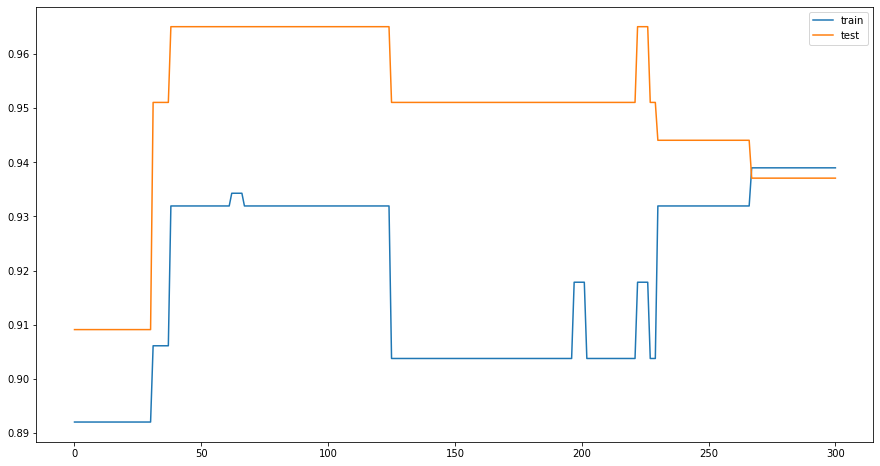

In [76]:
accuracy_test = bayesian_tree.path_acurracy(X_test, y_test)
accuracy_train = bayesian_tree.path_acurracy(X_train, y_train)

figure = plt.figure(figsize = (15,8))
plt.plot(list(range(len(accuracy_train))),accuracy_train, label = "train")
plt.plot(list(range(len(accuracy_test))),accuracy_test, label = "test")
plt.legend()
# plt.xscale("log")

In [70]:
bayesian_tree.dynamic_prob

[]

In [77]:
idx_test_max = np.argmax(accuracy_test)
idx_train_max = np.argmax(accuracy_train)
best_tree = bayesian_tree.path[idx_test_max]
best_tree.set_labels(feature_names,labels_names)
print(accuracy_test[idx_test_max])
#best_tree.save_img("Arboles/2")

0.965034965034965


In [11]:
bayesian_tree.chosen

[True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 Fa

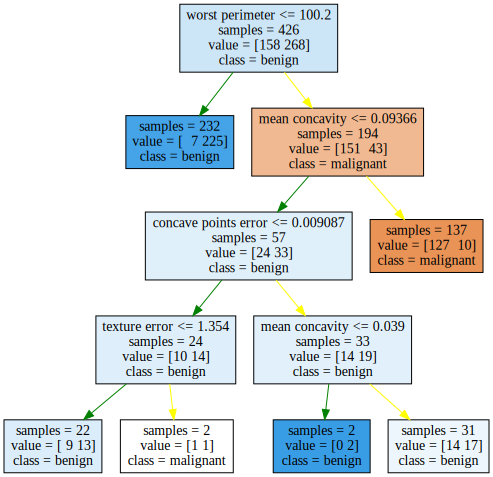

In [12]:
best_tree.graph_desiciontree()

In [ ]:
bayesian_tree

In [11]:
# bayesian_tree = BayesianDecisionTree(alpha=0.9 , beta= 2)
# bayesian_tree.fit(500,X_train,y_train)
# bayesian_tree.set_labels(feature_names,labels_names)
# bayesian_tree.render_changes("Cambios")

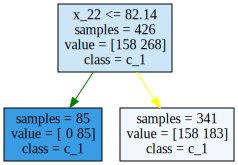

In [14]:
bayesian_tree.tree_changes()[1].graph_desiciontree()

In [13]:
np.array(bayesian_tree.choices)[bayesian_tree.chosen]

C:\Users\jorge\AppData\Local\Temp/ipykernel_21692/1146039359.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(bayesian_tree.choices)[bayesian_tree.chosen]


array(['start', list(['grow', 'swap', 'swap']),
       list(['change', 'change', 'change']),
       list(['grow', 'grow', 'grow']), list(['grow', 'swap', 'change']),
       list(['grow', 'prune', 'prune']), list(['prune', 'swap', 'grow']),
       list(['grow', 'change', 'prune']),
       list(['prune', 'prune', 'prune']), list(['swap', 'swap', 'grow']),
       list(['swap', 'swap', 'grow']), list(['grow', 'swap', 'swap']),
       list(['change', 'change', 'prune'])], dtype=object)

In [18]:
print(best_tree.write_dot3())

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0  [label="worst area <= 888.3\nsamples = 426\nvalue = [158 268]\nclass = benign", fillcolor="#cce6f8"];
0 -> 1 [color="green"];
1  [label="samples = 293\nvalue = [ 32 261]\nclass = benign", fillcolor="#64b2eb"];
0 -> 2 [color="yellow"];
2  [label="mean texture <= 15.51\nsamples = 133\nvalue = [126   7]\nclass = malignant", fillcolor="#e88e4e"];
2 -> 3 [color="green"];
3  [label="samples = 8\nvalue = [4 4]\nclass = malignant", fillcolor="#ffffff"];
2 -> 4 [color="yellow"];
4  [label="samples = 125\nvalue = [122   3]\nclass = malignant", fillcolor="#e68743"];
}


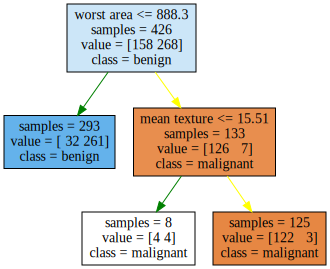

In [22]:
best_tree.graph_desiciontree()

In [59]:
from sklearn import datasets

In [121]:
iris = datasets.load_iris()
feature_names_iris = iris.feature_names
labels_names_iris = iris.target_names
X_iris = iris.data  # we only take the first two features.
y_iris = iris.target
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, random_state= 42)

In [122]:
bayesian_tree_iris = BayesianDecisionTree()
bayesian_tree_iris.fit(300,X_iris_train,y_iris_train)

prueba : 8.978226421951277
vector split stand: [0.5 0.5] 
prueba : 12.941370305688295
vector split stand: [0.31010205 0.31010205 0.3797959 ] 
prueba : -0.9242589015233449
vector split stand: [0.31010205 0.31010205 0.3797959 ] 
prueba : 7.503556485847213
prueba : 28.583100542311698
prueba : -13.516330658227531
vector prune stand: [0.5 0.5] 
else
prueba : -36.08665702815891
vector split stand: [0.25 0.25 0.25 0.25] 
prueba : -1.3359365168291077
prueba : -11.238425466073508
vector prune stand: [0.5 0.5] 
else
prueba : -36.08665702815891
prueba : -6.004696074694678
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
raw  
camino  
Se intento mucho
vector split stand: [0.25 0.25 0.25 0.25] 
prueba : -3.480334702220887
vector split stand: [0.25 0.25 0.25 0.25] 
prueba : -1.637729555055202
prueba : -7.3458322959520785
vector split stand: [0.25 0.25 0.25 0.25] 
prueba : -2.937377800

prueba : -1.0205439152982905
vector prune stand: [0.5 0.5] 
else
prueba : -10.310717908204452
vector split stand: [0.1830127  0.15849365 0.15849365 0.1830127  0.15849365 0.15849365] 
prueba : -0.8362480242006143
raw  110100
camino  2
raw  
camino  
raw  
camino  
raw  
camino  
raw  110100
camino  2
raw  110100
camino  2
raw  1
camino  1
raw  1
camino  1
raw  110100
camino  2
raw  
camino  
raw  
camino  
raw  1
camino  1
Se intento mucho
vector split stand: [0.1830127  0.15849365 0.15849365 0.1830127  0.15849365 0.15849365] 
prueba : -0.890972923889862
vector prune stand: [0.5 0.5] 
else
prueba : -10.310717908204452
vector split stand: [0.1830127  0.15849365 0.15849365 0.1830127  0.15849365 0.15849365] 
vector split stand: [0.1830127  0.15849365 0.15849365 0.1830127  0.15849365 0.15849365] 
vector split stand: [0.1830127  0.15849365 0.15849365 0.1830127  0.15849365 0.15849365] 
vector split stand: [0.1830127  0.15849365 0.15849365 0.1830127  0.15849365 0.15849365] 
prueba : 6.08721778

vector split stand: [0.26395571 0.16694025 0.16694025 0.18664487 0.21551893] 
prueba : -3.1441522786722587
vector split stand: [0.26395571 0.16694025 0.16694025 0.18664487 0.21551893] 
prueba : -2.303984673348488
raw  10
camino  2
raw  10
camino  2
raw  101
camino  21
raw  
camino  
raw  
camino  
raw  101
camino  21
raw  10
camino  2
raw  10
camino  2
raw  
camino  
raw  101
camino  21
raw  10
camino  2
raw  10
camino  2
Se intento mucho
vector prune stand: [1.] 
if
prueba : -2.538973871058303
vector split stand: [0.30952947 0.21887039 0.21887039 0.25272975] 
prueba : -1.0414538748281217
vector prune stand: [1.] 
if
prueba : -2.7543558741846113
prueba : -26.48109661942278
vector split stand: [0.30952947 0.21887039 0.21887039 0.25272975] 
prueba : -0.8239174117431531
raw  10
camino  2
raw  
camino  
raw  10
camino  2
raw  10
camino  2
raw  10
camino  2
raw  10
camino  2
raw  
camino  
raw  
camino  
raw  
camino  
raw  10
camino  2
raw  
camino  
raw  10
camino  2
Se intento mucho
raw 

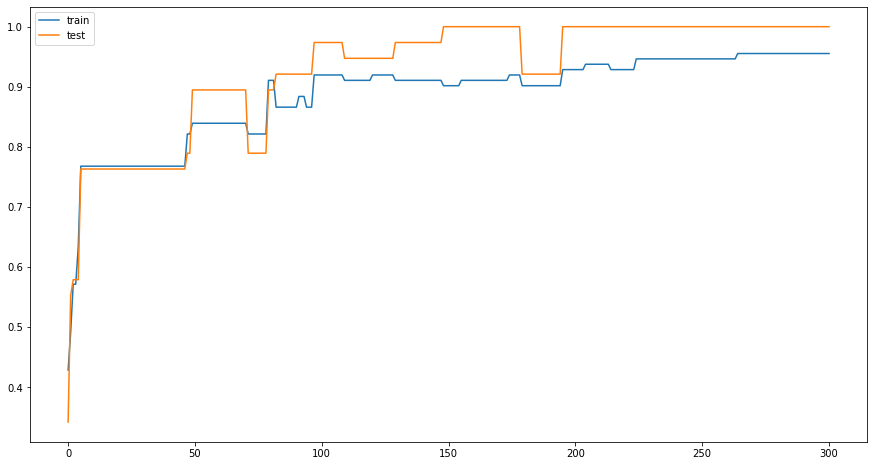

In [123]:
path_iris = bayesian_tree_iris.path
accuracy_iris_test = []
accuracy_iris_train = []
for i,tree in enumerate(path_iris):
    accuracy_iris_test.append(accuracy_score(tree.predict(X_iris_test), y_iris_test))
    accuracy_iris_train.append(accuracy_score(tree.predict(X_iris_train), y_iris_train))

figure = plt.figure(figsize = (15,8))
plt.plot(list(range(len(accuracy_iris_train))), accuracy_iris_train, label = "train")
plt.plot(list(range(len(accuracy_iris_test))), accuracy_iris_test, label = "test")
plt.legend()
# plt.xscale("log")

0.9736842105263158


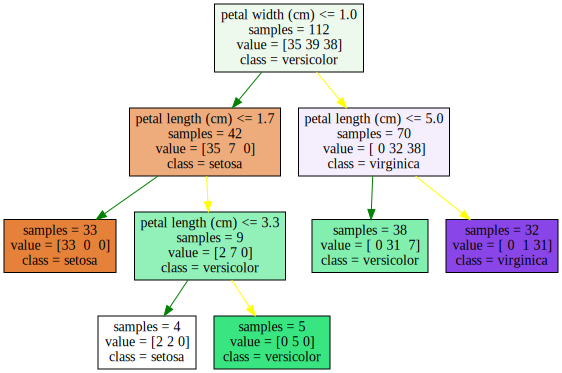

In [81]:
idx_test_max_iris = np.argmax(accuracy_iris_test)
idx_train_max_iris = np.argmax(accuracy_iris_train)
best_tree_iris = path_iris[idx_test_max_iris]
best_tree_iris.set_labels(feature_names_iris,labels_names_iris)
print(accuracy_iris_test[idx_test_max_iris])
best_tree_iris.graph_desiciontree()

In [124]:
bayesian_tree_iris.dynamic_prob

[[2, 0, 1, 0],
 [2, 0, 1, 0],
 [3, 1, 2, 1],
 [3, 1, 2, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [5, 2, 4, 2],
 [5, 2, 4, 2],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5, 3],
 [6, 2, 5,

In [273]:
# idx_test_max = np.argmax(accuracy_test)
# idx_train_max = np.argmax(accuracy_train)
# best_tree = path[idx_test_max]
# print(accuracy_test[idx_test_max])
# graph

In [324]:
  #T.split_MC4()
# root = T.light_root()
# graph = graphviz.Source(write_dot2(root, feature_names, labels_names), format="png") 
# graph

In [35]:
# root = T.light_root()
# graph = graphviz.Source(write_dot3(root, feature_names, labels_names, T.colors_rgb), format="png") 
# graph

In [121]:
# from sklearn.metrics import accuracy_score
# y_pred = T.predict(X_train)
# accuracy_score

# y_pred = T.predict(X_test)
# accuracy_score(y_test, y_pred)

In [122]:
import scipy as sp                             
from scipy.special import gammaln
from decimal import Decimal
from scipy import special
from numpy import exp

# a = np.sum( np.sum(gammaln(n + alphal1), axis = 1)  - gammaln(np.sum(n, axis =1) + np.sum(alphal)), axis = 0 )
# exp(a)

In [297]:
np.array(bayesian_tree_iris.choices)[bayesian_tree_iris.chosen]

array(['start', 'grow', 'prune', 'grow', 'prune', 'grow', 'grow', 'grow',
       'grow', 'change', 'grow', 'grow', 'prune', 'grow', 'prune',
       'prune', 'change', 'change', 'prune', 'grow', 'prune', 'change',
       'grow', 'prune', 'grow', 'grow', 'prune', 'prune', 'grow', 'swap',
       'prune', 'change', 'change', 'grow', 'prune', 'change', 'change',
       'prune', 'grow', 'prune', 'change', 'change', 'grow', 'prune',
       'change', 'change', 'change', 'change', 'prune', 'change', 'grow',
       'prune', 'change'], dtype='<U6')

In [129]:
labels_names

array(['malignant', 'benign'], dtype='<U9')

In [131]:
dt.shape

(426, 2)

In [130]:
len(feature_names)

30

In [137]:
np.shape(X_train)[-1]

30

vector split stand: [0.5 0.5] 
vector split stand: [0.31485363 0.31485363 0.37029275] 


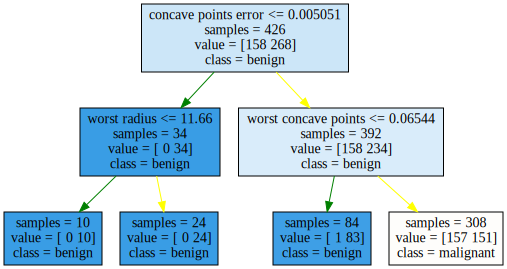

In [22]:
dt =  DecisionTree(alpha= 1, beta = 0.4)
dt.fit_MC(X_train, y_train)
dt.set_labels(feature_names,labels_names)
dt.split_MC4()
dt.split_MC4()
root = dt.light_root()
#print(root)
graph = dt.graph_desiciontree()
# print(dt.P_YX(np.array([0.5,0.5])))
# n = n.astype('np.float128')
graph

In [196]:
dt.alpha_prior

array([0.5, 0.5])

In [142]:
print(dt.write_dot2())

digraph Tree {
node [shape=box, style="filled", color="skyblue"] ;
0  [label="compactness error <= 0.02569\nsamples = 426\nvalue = [158 268]\nclass = benign", fillcolor=orange];
0 -> 1 [color="green"];
1  [label="worst smoothness <= 0.1218\nsamples = 267\nvalue = [ 69 198]\nclass = benign", fillcolor=orange];
1 -> 2 [color="green"];
2  [label="samples = 103\nvalue = [ 9 94]\nclass = benign", fillcolor=orange];
1 -> 3 [color="yellow"];
3  [label="fractal dimension error <= 0.003345\nsamples = 164\nvalue = [ 60 104]\nclass = benign", fillcolor=orange];
3 -> 4 [color="green"];
4  [label="samples = 118\nvalue = [46 72]\nclass = benign", fillcolor=orange];
3 -> 5 [color="yellow"];
5  [label="samples = 46\nvalue = [14 32]\nclass = benign", fillcolor=orange];
0 -> 6 [color="yellow"];
6  [label="samples = 159\nvalue = [89 70]\nclass = malignant", fillcolor=orange];
}


In [90]:

texcode = dot2tex.dot2tex(dt.write_dot2(), format='tikz', crop=True)

In [92]:
print(texcode)

\documentclass{article}
\usepackage[x11names, svgnames, rgb]{xcolor}
\usepackage[utf8]{inputenc}
\usepackage{tikz}
\usetikzlibrary{snakes,arrows,shapes}
\usepackage{amsmath}
%
%

\usepackage[active,tightpage]{preview}
\PreviewEnvironment{tikzpicture}
\setlength\PreviewBorder{0pt}%

%

\begin{document}
\pagestyle{empty}
%
%
%

\enlargethispage{100cm}
% Start of code
\begin{tikzpicture}[>=latex',line join=bevel,]
%%
\node (0) at (121.5bp,331.0bp) [draw=skyblue,fill=orange,rectangle] {\$x\_25\$ <= 0.1546$\backslash$nsamples = 426$\backslash$nvalue = [158 268]$\backslash$nclass = \$c\_1\$};
  \node (1) at (55.5bp,227.0bp) [draw=skyblue,fill=orange,rectangle] {samples = 125$\backslash$nvalue = [ 11 114]$\backslash$nclass = \$c\_1\$};
  \node (2) at (188.5bp,227.0bp) [draw=skyblue,fill=orange,rectangle] {\$x\_5\$ <= 0.06031$\backslash$nsamples = 301$\backslash$nvalue = [147 154]$\backslash$nclass = \$c\_1\$};
  \node (3) at (122.5bp,123.0bp) [draw=skyblue,fill=orange,rectangle] {\$x\_21\$ <=

In [77]:
dt.nodes

[0, 1, 2, 3, 4, 5, 6]

In [76]:
print(dt.write_dot())

digraph Tree {
node [shape=box, style="filled", color="skyblue"] ;
0 -> 1 [color="green"];
1 -> 2 [color="green"];
1 -> 3 [color="yellow"];
0 -> 4 [color="yellow"];
4 -> 5 [color="green"];
4 -> 6 [color="yellow"];
}


In [ ]:
dt2 = dt.copy()

# Sección nueva

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


<Figure size 432x288 with 0 Axes>

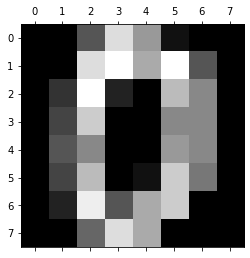

In [125]:
from sklearn.datasets import load_digits
digits=load_digits()
plt.gray() 
plt.matshow(digits.images[0]) 
print(digits.images[0])
plt.show() 

In [126]:
n_samples = len(digits.images)
data_digit = digits.images.reshape((n_samples, -1))
digits_target = digits.target
# digits_target0 =  digits_target[digits_target==0]
# digits_target1 =  digits_target[digits_target==1]
# digits_target2 =  digits_target[digits_target==2]
# digits_target2 =  digits_target[digits_target==3]

# data_digit0 =  data_digit[digits_target==0]
# data_digit1 =  data_digit[digits_target==1]
# data_digit2 =  data_digit[digits_target==2]

# data_digit = np.concatenate((data_digit0,data_digit1,data_digit2))
# digits_target = np.concatenate((digits_target0,digits_target1,digits_target2))

X_train_digit, X_test_digit, y_train_digit, y_test_digit = train_test_split(
    data_digit, digits_target, test_size=0.5, shuffle=True , random_state=22)

In [127]:
feature_name_digit = digits.feature_names
labels_names_digit = digits.target_names

In [137]:
bayesian_tree_digit = BayesianDecisionTree(alpha=0.000001, beta= 0.5,prob = [0.01,0.01,0.49,0.49])
bayesian_tree_digit.fit(300,X_train_digit ,y_train_digit)

prueba : -75.3405867109384
prueba : -9.509493521797367
prueba : 138.31456844015338
prueba : -21.01938134411307
vector split stand: [0.5 0.5] 
prueba : 24.5853733342783
raw  
camino  
1 intentos 
prueba : 60.157772591842786
raw  
camino  
1 intentos 
prueba : -60.157772591842786
prueba : -136.2679748326168
prueba : -126.34242655371327
raw  
camino  
1 intentos 
prueba : -60.157772591842786
raw  
camino  
1 intentos 
prueba : -60.157772591842786
raw  
camino  
1 intentos 
prueba : -60.157772591842786
prueba : -104.41428056140376
vector prune stand: [1.] 
if
prueba : -173.15289400382062
prueba : -84.54900476621674
prueba : 12.67741177547714
prueba : -67.57916514920817
prueba : -143.5202396841164
prueba : -97.36400835794461
prueba : -93.68086415867765
prueba : -193.37142010255639
raw  
camino  
1 intentos 
prueba : -45.025097633902305
prueba : -32.124541004899584
prueba : -13.173851349932647
raw  
camino  
1 intentos 
prueba : -45.025097633902305
prueba : -97.65794172339088
prueba : -123.1

prueba : -94.37150082293806
prueba : -319.1580659374831
raw  
camino  
1 intentos 
prueba : -81.71177645813577
prueba : -92.16080199513294
prueba : -100.70711288412258
raw  
camino  
1 intentos 
prueba : -81.71177645813577
prueba : -12.553923237137496
raw  
camino  
1 intentos 
prueba : -81.71177645813577
raw  
camino  
1 intentos 
prueba : -81.71177645813577
prueba : -145.37046224083997
prueba : -91.06050170919411
raw  
camino  
1 intentos 
prueba : -81.71177645813577
raw  
camino  
1 intentos 
prueba : -81.71177645813577
vector split stand: [0.25 0.25 0.25 0.25] 
prueba : 0.032787054272375826
raw  
camino  
1 intentos 
prueba : -5.651842129416764
prueba : -84.4165933882125
prueba : -237.47181949768765
prueba : -94.7579177360758
prueba : -250.5362104107994
prueba : -181.97806716798254
prueba : -186.10357123355357
prueba : -227.45077807660527
prueba : -122.59061712022276
prueba : -100.99991379572384
prueba : -247.74211736491134
prueba : -95.73911059484226
prueba : -63.69557678228762
pr

In [173]:
bayesian_tree_digit.set_alpha(1)
bayesian_tree_digit.set_prob([0.2,0.2,0.3,0.3])

In [177]:
bayesian_tree_digit.fit(400,X_train_digit ,y_train_digit)

vector split stand: [0.08510492 0.08510492 0.08510492 0.07612015 0.07612015 0.08510492
 0.08510492 0.06948788 0.06948788 0.06948788 0.06433327 0.06433327
 0.08510492] 
prueba : -5.541468297291885
raw  111001010011001
camino  221
1 intentos 
prueba : -26.98749900400867
prueba : -95.16812987798221
prueba : -453.9938179338301
raw  111001010011001
camino  221
1 intentos 
prueba : -26.98749900400867
vector split stand: [0.08510492 0.08510492 0.08510492 0.07612015 0.07612015 0.08510492
 0.08510492 0.06948788 0.06948788 0.06948788 0.06433327 0.06433327
 0.08510492] 
vector split stand: [0.08510492 0.08510492 0.08510492 0.07612015 0.07612015 0.08510492
 0.08510492 0.06948788 0.06948788 0.06948788 0.06433327 0.06433327
 0.08510492] 
vector prune stand: [0.19999998 0.2        0.19999998 0.20000001 0.20000002] 
else
prueba : -4.5747624426935545
vector split stand: [0.09045811 0.09045811 0.09045811 0.08090819 0.08090819 0.09045811
 0.09045811 0.07385874 0.07385874 0.07385874 0.07385874 0.09045811]

raw  11100101001100
camino  22
1 intentos 
prueba : -79.57892206532483
raw  
camino  
1 intentos 
prueba : -294.9874675345368
prueba : -345.5533189438793
vector prune stand: [0.19999999 0.2        0.19999999 0.20000001 0.20000001] 
else
prueba : -47.24447411143319
prueba : -79.68343561025085
vector split stand: [0.09045811 0.09045811 0.09045811 0.08090819 0.08090819 0.09045811
 0.09045811 0.07385874 0.07385874 0.07385874 0.07385874 0.09045811] 
prueba : -9.533857357565012
prueba : -207.3663938671898
vector split stand: [0.09045811 0.09045811 0.09045811 0.08090819 0.08090819 0.09045811
 0.09045811 0.07385874 0.07385874 0.07385874 0.07385874 0.09045811] 
prueba : -8.283678159263445
raw  11100
camino  12
1 intentos 
prueba : -11.517159190671237
vector split stand: [0.09045811 0.09045811 0.09045811 0.08090819 0.08090819 0.09045811
 0.09045811 0.07385874 0.07385874 0.07385874 0.07385874 0.09045811] 
prueba : -2.3588514360619683
vector prune stand: [0.19999999 0.2        0.19999999 0.2000000

1 intentos 
prueba : -277.4691150017652
raw  1110010100
camino  2
1 intentos 
prueba : -203.55602922430876
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.

raw  1110010100
camino  2
1 intentos 
prueba : -194.65031696559095
raw  1
camino  1
1 intentos 
prueba : -8.090575493717324
vector prune stand: [0.24999999 0.25000001 0.24999999 0.25000002] 
else
prueba : -47.24447411143319
raw  11100
camino  12
1 intentos 
prueba : -11.517159190671237
raw  111001010011001
camino  221
1 intentos 
prueba : -49.34386014888969
prueba : -59.197753583516715
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
prueba : -8.539107338798885
prueba : -214.92556545841035
raw  
camino  
1 intentos 
prueba : -216.48268061614363
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
prueba : -6.431460519677785
raw  1110010100
camino  2
1 intentos 
prueba : -194.65031696559095
vector prune stand: [0.24999999 0.25000001 0.24999999 0.25000002] 
if
prueba : -75.72997426722986
raw  1110010100

prueba : -6.205112649588955
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0867006  0.07914646 0.07914646 0.09693422] 
vector split stand: [0.09693422 0.09693422 0.09693422 0.0867006  0.0867006  0.09693422
 0.09693422 0.0

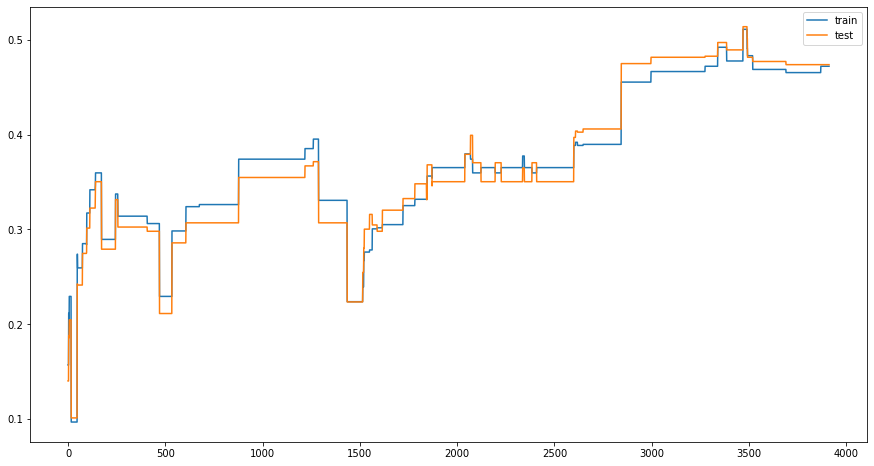

In [178]:
path_digit = bayesian_tree_digit.path
accuracy_digit_test = []
accuracy_digit_train = []
for i,tree in enumerate(path_digit):
    accuracy_digit_test.append(accuracy_score(tree.predict(X_test_digit), y_test_digit))
    accuracy_digit_train.append(accuracy_score(tree.predict(X_train_digit), y_train_digit))

figure = plt.figure(figsize = (15,8))
plt.plot(list(range(len(accuracy_digit_train))), accuracy_digit_train, label = "train")
plt.plot(list(range(len(accuracy_digit_test))), accuracy_digit_test, label = "test")
plt.legend()
# plt.xscale("log")

In [165]:
# bayesian_tree_digit = BayesianDecisionTree(alpha=0.08, beta= 0.4,prob = [0.1,0.1,0.4,0.4])
# bayesian_tree_digit.fit_batch(200,2,X_train_digit ,y_train_digit)

In [166]:
# path_digit = bayesian_tree_digit.path
# accuracy_digit_test = []
# accuracy_digit_train = []
# for i,tree in enumerate(path_digit):
#     accuracy_digit_test.append(accuracy_score(tree.predict(X_test_digit), y_test_digit))
#     accuracy_digit_train.append(accuracy_score(tree.predict(X_train_digit), y_train_digit))

# figure = plt.figure(figsize = (15,8))
# plt.plot(list(range(len(accuracy_digit_train))), accuracy_digit_train, label = "train")
# plt.plot(list(range(len(accuracy_digit_test))), accuracy_digit_test, label = "test")
# plt.legend()
# # plt.xscale("log")

0.5139043381535039


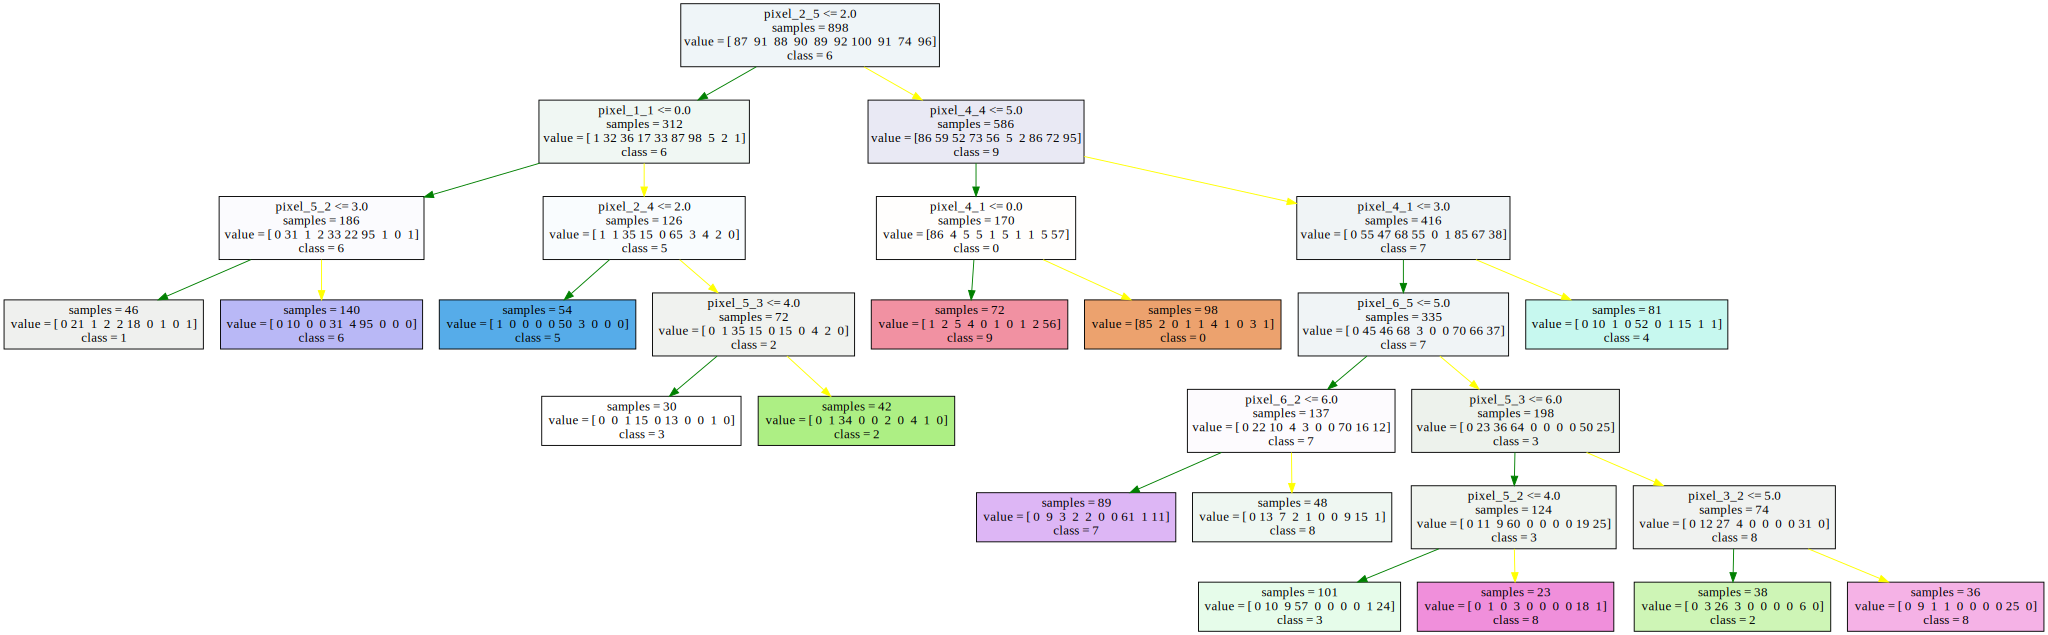

In [179]:
idx_test_max_digit = np.argmax(accuracy_digit_test)
idx_train_max_digit = np.argmax(accuracy_digit_train)
best_tree_digit = path_digit[idx_test_max_digit]
best_tree_digit.set_labels(feature_name_digit,labels_names_digit)
print(accuracy_digit_test[idx_test_max_digit])
best_tree_digit.graph_desiciontree()

In [168]:
np.array(bayesian_tree_digit.choices)[bayesian_tree_digit.chosen]

array(['start', 'change', 'grow', 'swap', 'change', 'change', 'change',
       'grow', 'change', 'change', 'change', 'change', 'change', 'change',
       'change', 'change', 'start', 'start', 'change', 'change', 'start',
       'grow', 'swap', 'start', 'change', 'change', 'start', 'change',
       'start', 'change', 'grow', 'change', 'change', 'start', 'grow',
       'change', 'grow', 'change', 'grow', 'change', 'change', 'change',
       'change', 'change', 'change', 'grow', 'grow', 'change', 'change',
       'change', 'swap', 'change', 'swap', 'start', 'grow', 'swap',
       'prune', 'swap', 'swap', 'swap', 'start', 'grow', 'prune', 'grow',
       'swap', 'swap', 'change', 'grow', 'change', 'prune', 'swap'],
      dtype='<U6')

              precision    recall  f1-score   support

           0       0.77      0.69      0.73        91
           1       0.29      0.22      0.25        91
           2       0.66      0.64      0.65        89
           3       0.73      0.60      0.66        93
           4       0.77      0.86      0.81        92
           5       0.91      0.66      0.76        90
           6       0.79      0.90      0.84        81
           7       0.54      0.88      0.67        88
           8       0.36      0.55      0.44       100
           9       0.50      0.19      0.28        84

    accuracy                           0.62       899
   macro avg       0.63      0.62      0.61       899
weighted avg       0.63      0.62      0.61       899

[[63  5  1  1  7  0  0  3 11  0]
 [ 3 20  8  2 12  0  7  9 29  1]
 [ 0  4 57 10  0  0  3  0 14  1]
 [ 2  7  3 56  0  0  1 17  7  0]
 [ 0  4  1  0 79  0  2  4  1  1]
 [ 2  4  1  0  4 59  3  5  3  9]
 [ 0  3  0  0  0  0 73  1  4  0]
 [ 0  0  1

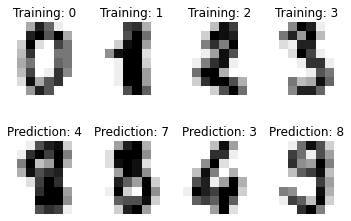

In [63]:
y_pred_digit = best_tree_digit.predict(X_test_digit)

_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

    images_and_predictions = list(zip(digits.images[n_samples // 2:], y_pred_digit))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print((metrics.classification_report(y_test_digit, y_pred_digit)))
print((metrics.confusion_matrix(y_test_digit, y_pred_digit)))

In [109]:
bayesian_tree_digit_batch = BayesianDecisionTree(alpha=0.99, beta= 0.3)
bayesian_tree_digit_batch.fit_batch(20, 3,X_train_digit ,y_train_digit)

No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
Se intento mucho
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
Se intento mucho
prueba : -243.32689198850767
Árbol minimo no se puede podar
Árbol minimo no se puede podar
prueba : -77.31663685367221
vector stand: [0.5 0.5] 
vector stand: [0.5 0.5] 
prueba : -15.645841350872615
vector stand: [0.5 0.5] 
prueba : -149.12571231889024
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
No swap posible
Se intento mucho
Árbol minimo no se puede podar
Árbol minimo no se puede podar
prueba : 0.0
Árbol minimo no se puede podar
Árbol minimo no

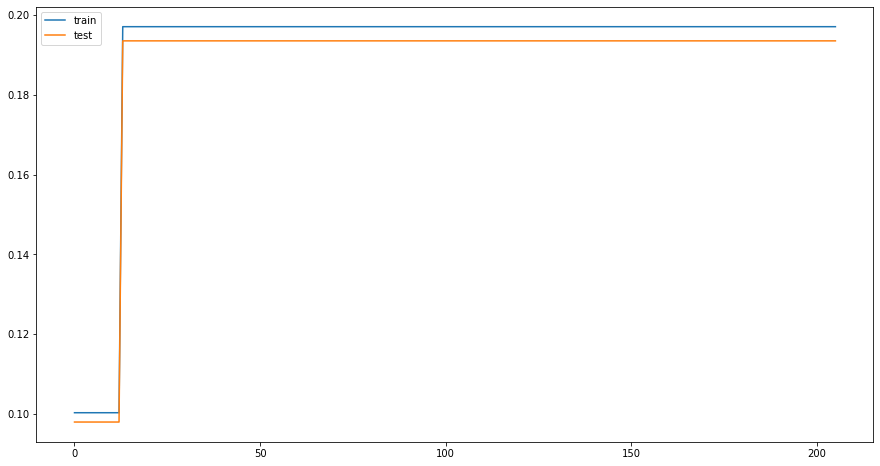

In [122]:
path_digit_batch = bayesian_tree_digit_batch.path
accuracy_digit_test_batch = []
accuracy_digit_train_batch = []
for i,tree in enumerate(path_digit_batch):
    accuracy_digit_test_batch.append(accuracy_score(tree.predict(X_test_digit), y_test_digit))
    accuracy_digit_train_batch.append(accuracy_score(tree.predict(X_train_digit), y_train_digit))

figure = plt.figure(figsize = (15,8))
plt.plot(list(range(len(accuracy_digit_train_batch))), accuracy_digit_train_batch, label = "train")
plt.plot(list(range(len(accuracy_digit_test_batch))), accuracy_digit_test_batch, label = "test")
plt.legend()
# plt.xscale("log")

In [117]:
bayesian_tree_digit_batch.fit(60,X_train_digit ,y_train_digit)

raw  1110011001
camino  1221
1 intentos 
prueba : 2.2700949255695377
vector stand: [0.08249597 0.08249597 0.07715423 0.07715423 0.06974632 0.06700755
 0.06700755 0.0730475  0.07715423 0.08993202 0.08249597 0.07715423
 0.07715423] 
prueba : -6.158807212441843
vector stand: [0.08249597 0.08249597 0.07715423 0.07715423 0.06974632 0.06700755
 0.06700755 0.0730475  0.07715423 0.08993202 0.08249597 0.07715423
 0.07715423] 
vector stand: [0.08249597 0.08249597 0.07715423 0.07715423 0.06974632 0.06700755
 0.06700755 0.0730475  0.07715423 0.08993202 0.08249597 0.07715423
 0.07715423] 
raw  111001100
camino  122
1 intentos 
prueba : 0.0
raw  11
camino  11
if
node split index : 0
prueba : -42.07772188711738
prueba : -6.622180935467668
vector stand: [0.08249597 0.08249597 0.07715423 0.07715423 0.06974632 0.06700755
 0.06700755 0.0730475  0.07715423 0.08993202 0.08249597 0.07715423
 0.07715423] 
prueba : -0.9162907318739144
raw  11100110011101000100
camino  2
1 intentos 
prueba : -19.88603931834905

In [121]:
bayesian_tree_digit_batch.fit_batch(20, 5,X_train_digit ,y_train_digit)

raw  111110100001100111100000101
camino  221
if
node split index : 13
vector stand: [0.06050994 0.05777536 0.05777536 0.0639118  0.06833671 0.0639118
 0.0639118  0.05550666 0.05550666 0.05777536 0.06050994 0.0639118
 0.07449647 0.06833671 0.0639118  0.0639118 ] 
vector stand: [0.05724101 0.05465417 0.05465417 0.05724101 0.05724101 0.06464496
 0.0604591  0.0604591  0.05250803 0.05250803 0.05465417 0.05724101
 0.0604591  0.07047195 0.06464496 0.0604591  0.0604591 ] 
vector stand: [0.05724101 0.05465417 0.05465417 0.05724101 0.05724101 0.06464496
 0.0604591  0.0604591  0.05250803 0.05250803 0.05465417 0.05724101
 0.0604591  0.07047195 0.06464496 0.0604591  0.0604591 ] 
vector stand: [0.05457439 0.05210806 0.05210806 0.05457439 0.05457439 0.06163343
 0.05764257 0.05764257 0.04832385 0.04832385 0.0500619  0.05210806
 0.05457439 0.05764257 0.06718896 0.06163343 0.05764257 0.05764257] 
prueba : 25.207011869982807
vector stand: [0.05190116 0.04955563 0.04955563 0.05190116 0.05190116 0.05861442

vector stand: [0.0454849  0.04342934 0.04342934 0.0454849  0.0454849  0.05136823
 0.0454849  0.0454849  0.04804206 0.03902228 0.03902228 0.0402754
 0.04172397 0.04342934 0.0454849  0.0454849  0.0454849  0.05599848
 0.05136823 0.04804206 0.0454849  0.0454849 ] 
prueba : -547.8323144913975
raw  
camino  
raw  11111010010001
camino  121
raw  11111010010001110001
camino  1221
raw  111
camino  111
raw  11111010010001
camino  121
raw  1
camino  1
raw  1111101001000111000111
camino  122111
raw  1111
camino  1111
raw  11111010010001
camino  121
raw  1111101001000111000111
camino  122111
raw  111110100100011100011111000000
camino  2
raw  111110100100011100011
camino  12211
Se intento mucho
vector stand: [0.05190116 0.04955563 0.04955563 0.05190116 0.05190116 0.05861442
 0.05190116 0.05190116 0.05481904 0.04595679 0.04595679 0.0476097
 0.04955563 0.05190116 0.05481904 0.06389783 0.05861442 0.05481904
 0.05481904] 
vector stand: [0.05190116 0.04955563 0.04955563 0.05190116 0.05190116 0.05861442
 

0.1935483870967742


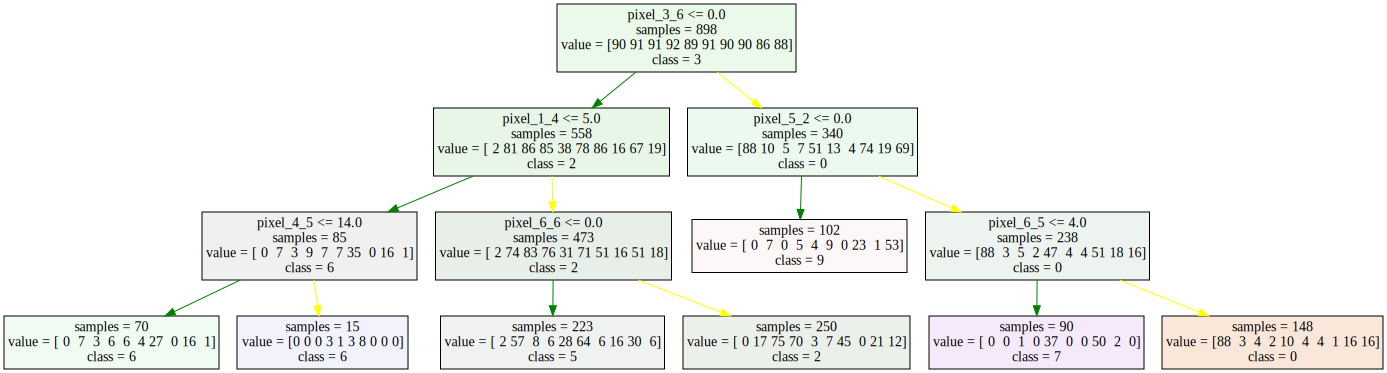

In [111]:
idx_test_max_digit_batch = np.argmax(accuracy_digit_test_batch)
idx_train_max_digit_batch = np.argmax(accuracy_digit_train_batch)
best_tree_digit_batch = path_digit_batch[idx_test_max_digit_batch]
best_tree_digit_batch.set_labels(feature_name_digit,labels_names_digit)
print(accuracy_digit_test_batch[idx_test_max_digit_batch])
best_tree_digit_batch.graph_desiciontree()

In [91]:
np.array(bayesian_tree_digit_batch.choices)[bayesian_tree_digit_batch.chosen]

C:\Users\jorge\AppData\Local\Temp/ipykernel_20196/2667462199.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(bayesian_tree_digit_batch.choices)[bayesian_tree_digit_batch.chosen]


array(['start', list(['prune', 'prune', 'prune']),
       list(['change', 'prune', 'change']),
       list(['change', 'change', 'swap']),
       list(['prune', 'prune', 'grow']),
       list(['grow', 'change', 'prune']),
       list(['change', 'change', 'prune']),
       list(['grow', 'grow', 'swap']), list(['prune', 'prune', 'grow']),
       list(['prune', 'grow', 'grow']), list(['grow', 'swap', 'grow']),
       list(['grow', 'grow', 'prune']), list(['swap', 'change', 'grow']),
       list(['change', 'grow', 'change']),
       list(['change', 'grow', 'change']),
       list(['prune', 'change', 'grow']), list(['swap', 'swap', 'grow']),
       list(['grow', 'swap', 'grow']), list(['prune', 'grow', 'prune']),
       list(['change', 'swap', 'change']),
       list(['grow', 'grow', 'prune']), list(['prune', 'grow', 'prune']),
       list(['grow', 'grow', 'grow']), list(['prune', 'grow', 'grow']),
       list(['prune', 'change', 'grow']), list(['grow', 'prune', 'swap']),
       list(['grow'